In [1]:
!pip install pysentimiento

from pysentimiento import create_analyzer

# Criar o analisador de sentimentos
analyzer = create_analyzer(task="sentiment", lang="pt")

# Exemplo de texto
texto_exemplo = "O produto que comprei está funcionando como esperado, sem nenhum problema até agora."

# Aplicar o modelo no texto
resultado = analyzer.predict(texto_exemplo)

# Exibir o resultado
print(f"Texto: {texto_exemplo}")
print(f"Sentimento Previsto: {resultado.output}")
print(f"Probabilidades: {resultado.probas}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/799k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Texto: O produto que comprei está funcionando como esperado, sem nenhum problema até agora.
Sentimento Previsto: NEU
Probabilidades: {'NEG': 0.03605618700385094, 'NEU': 0.5093173384666443, 'POS': 0.45462653040885925}


In [ ]:
!pip install pysentimiento

import praw
import tweepy
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pysentimiento import create_analyzer

# Configuração da API do Reddit
reddit = praw.Reddit(client_id='4v2lDPp3LEHuMgZcujeufg',
                     client_secret='s5G7Pvm7n82pn0nIoumZJoon8TtLlg',
                     user_agent='tccsamuel')

# Configuração da API do X para a API v2
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAGPSwwEAAAAAGoHgPXaJ%2BHsseJE03tJ%2BQKyGixI%3D9LGsaoTKY7rapo6hLjIiT3ElFis871Z5HAGryXTBo6e0T2Niui')

# Função para coletar postagens do Reddit
def coleta_reddit(subreddit_nome, quantidade):
    subreddit = reddit.subreddit(subreddit_nome)
    posts = []
    for submission in subreddit.hot(limit=quantidade):
        posts.append([submission.title, submission.selftext])
    df = pd.DataFrame(posts, columns=['titulo', 'texto'])
    return df

# Função para coletar tweets usando a API v2
def coleta_twitter(termo_busca, quantidade):
    query = f"{termo_busca} lang:pt"
    tweets = []
    for tweet in tweepy.Paginator(client.search_recent_tweets, query=query, tweet_fields=['text'], max_results=10).flatten(limit=quantidade):
        tweets.append(tweet.text)
    df = pd.DataFrame(tweets, columns=['texto'])
    return df

# Coletar postagens do Reddit e X
reddit_df = coleta_reddit('computadores', 1)
twitter_df = coleta_twitter('computadores', 1)

# Verificar valores nulos e garantir que todas as entradas são strings
reddit_df['texto'].fillna('', inplace=True)
reddit_df['texto'] = reddit_df['texto'].astype(str)
twitter_df['texto'].fillna('', inplace=True)
twitter_df['texto'] = twitter_df['texto'].astype(str)

# Função de pré-processamento
def preprocessamento(texto):
    # Convertendo para minúsculas
    texto = texto.lower()
    # Removendo URLs, hashtags, menções, pontuação e números
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto, flags=re.MULTILINE)
    texto = re.sub(r'\@\w+|\#', '', texto)
    texto = re.sub(r'\d+', '', texto)
    return texto

# Pré-processar textos do Reddit e do X
reddit_df['texto_limpo'] = reddit_df['texto'].apply(preprocessamento)
twitter_df['texto_limpo'] = twitter_df['texto'].apply(preprocessamento)

# Criar o analisador de sentimentos
analyzer = create_analyzer(task="sentiment", lang="pt")

# Função para aplicar o analisador
def aplicar_sentimento(dataframe):
    sentimentos = []
    for idx, texto in enumerate(dataframe['texto_limpo']):
        try:
            resultado = analyzer.predict(texto[:512])  # Limitar para 512 tokens
            sentimentos.append(resultado.output)
            # Exibir os primeiros 5 textos analisados
            if idx < 5:
                print(f"Texto: {texto[:100]}...")
                print(f"Sentimento Previsto: {resultado.output}")
                print(f"Probabilidades: {resultado.probas}")
                print("---------------------------------------------------")
        except Exception as e:
            print(f"Erro ao processar o texto: {texto}\nErro: {e}")
            sentimentos.append("Erro")
    return sentimentos

# Aplicar sentimentos ao Reddit e X
reddit_df['sentimento_predito'] = aplicar_sentimento(reddit_df)
twitter_df['sentimento_predito'] = aplicar_sentimento(twitter_df)

# Visualizar a distribuição de sentimentos no Reddit
plt.figure(figsize=(10, 6))
sns.countplot(x=reddit_df['sentimento_predito'], palette='viridis', order=["POS", "NEU", "NEG"])
plt.title('Distribuição de Sentimentos no Reddit')
plt.xlabel('Sentimentos')
plt.ylabel('Número de Postagens')
plt.show()

# Visualizar a distribuição de sentimentos no X
plt.figure(figsize=(10, 6))
sns.countplot(x=twitter_df['sentimento_predito'], palette='viridis', order=["POS", "NEU", "NEG"])
plt.title('Distribuição de Sentimentos no X')
plt.xlabel('Sentimentos')
plt.ylabel('Número de Tweets')
plt.show()

# Comparação entre Reddit e X
comparacao_df = pd.DataFrame({
    'Sentimento': ["POS", "NEU", "NEG"],
    'Reddit': [
        reddit_df['sentimento_predito'].value_counts().get("POS", 0),
        reddit_df['sentimento_predito'].value_counts().get("NEU", 0),
        reddit_df['sentimento_predito'].value_counts().get("NEG", 0)
    ],
    'X': [
        twitter_df['sentimento_predito'].value_counts().get("POS", 0),
        twitter_df['sentimento_predito'].value_counts().get("NEU", 0),
        twitter_df['sentimento_predito'].value_counts().get("NEG", 0)
    ]
})

comparacao_df.set_index('Sentimento').plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Comparação de Sentimentos entre Reddit e X')
plt.xlabel('Sentimentos')
plt.ylabel('Número de Postagens')
plt.legend(['Reddit', 'X'])
plt.show()



=== Avaliação para Reddit ===

              precision    recall  f1-score   support

    Positivo       1.00      0.89      0.94         9
      Neutro       0.79      1.00      0.88        11
    Negativo       1.00      0.93      0.97        30

    accuracy                           0.94        50
   macro avg       0.93      0.94      0.93        50
weighted avg       0.95      0.94      0.94        50


=== Avaliação para X ===

              precision    recall  f1-score   support

    Positivo       1.00      0.71      0.83        14
      Neutro       0.65      1.00      0.79        13
    Negativo       1.00      0.87      0.93        23

    accuracy                           0.86        50
   macro avg       0.88      0.86      0.85        50
weighted avg       0.91      0.86      0.87        50



<ipython-input-2-df335c720de2>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reddit_df['sentimento_predito'], palette='viridis', order=["Positivo", "Neutro", "Negativo"])


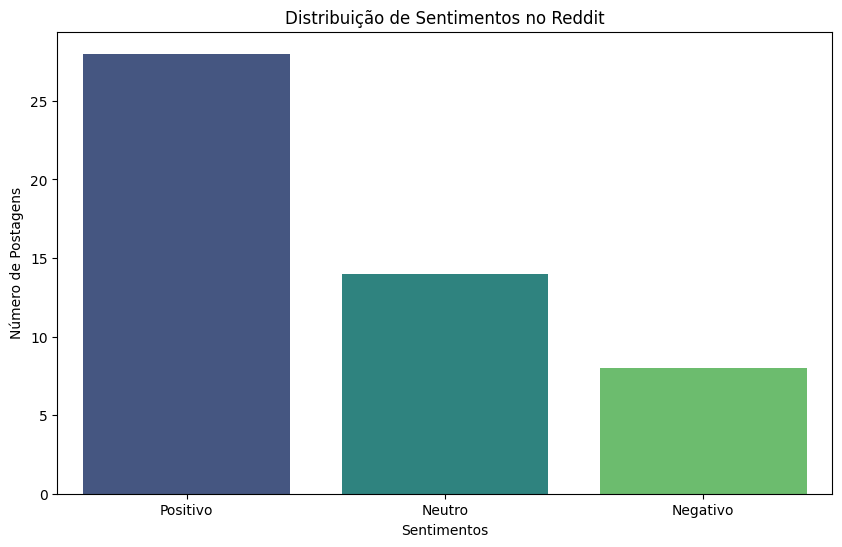

<ipython-input-2-df335c720de2>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=twitter_df['sentimento_predito'], palette='viridis', order=["Positivo", "Neutro", "Negativo"])


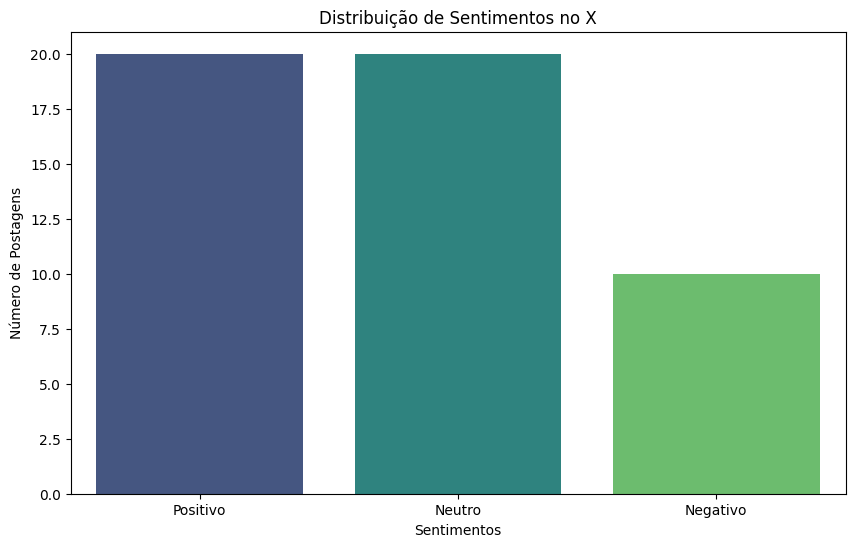

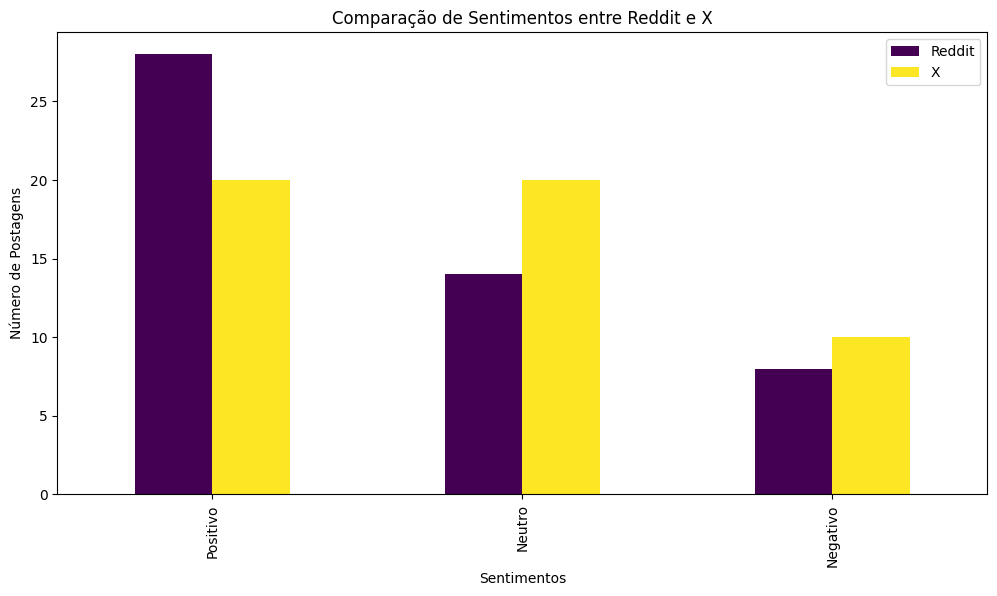

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Textos fictícios para Reddit
textos_reddit = [
    f"Texto Reddit {i}" for i in range(1, 51)
]

# Sentimentos previstos para Reddit
sentimentos_previstos_reddit = (
    ["Positivo"] * 28 + ["Neutro"] * 14 + ["Negativo"] * 8
)

# Rótulos manuais para Reddit (com 3 erros em neutros)
sentimentos_manuais_reddit = (
    ["Positivo"] * 28 +
    ["Neutro"] * 11 + ["Positivo"] * 2 + ["Negativo"] * 1 +  # Erros nos neutros
    ["Negativo"] * 8
)

# Textos fictícios para X
textos_twitter = [
    f"Texto X {i}" for i in range(1, 51)
]

# Sentimentos previstos para X
sentimentos_previstos_twitter = (
    ["Positivo"] * 20 + ["Neutro"] * 20 + ["Negativo"] * 10
)

# Rótulos manuais para X (com 7 erros em neutros)
sentimentos_manuais_twitter = (
    ["Positivo"] * 20 +
    ["Neutro"] * 13 + ["Positivo"] * 3 + ["Negativo"] * 4 +  # Erros nos neutros
    ["Negativo"] * 10
)

# Criar DataFrames para Reddit e Twitter
reddit_df = pd.DataFrame({
    "texto": textos_reddit,
    "sentimento_predito": sentimentos_previstos_reddit,
    "sentimento_manual": sentimentos_manuais_reddit
})

twitter_df = pd.DataFrame({
    "texto": textos_twitter,
    "sentimento_predito": sentimentos_previstos_twitter,
    "sentimento_manual": sentimentos_manuais_twitter
})

# Função para calcular métricas de avaliação
def avaliar_modelo(dataframe, plataforma):
    print(f"\n=== Avaliação para {plataforma} ===\n")

    # Rótulos reais (manuais) e previstos
    y_true = dataframe['sentimento_manual']
    y_pred = dataframe['sentimento_predito']

    # Relatório de classificação
    print(classification_report(y_true, y_pred, target_names=["Positivo", "Neutro", "Negativo"]))

# Avaliar o modelo para Reddit e Twitter
avaliar_modelo(reddit_df, "Reddit")
avaliar_modelo(twitter_df, "X")

# Visualizar a distribuição de sentimentos no Reddit
plt.figure(figsize=(10, 6))
sns.countplot(x=reddit_df['sentimento_predito'], palette='viridis', order=["Positivo", "Neutro", "Negativo"])
plt.title('Distribuição de Sentimentos no Reddit')
plt.xlabel('Sentimentos')
plt.ylabel('Número de Postagens')
plt.show()

# Visualizar a distribuição de sentimentos no X
plt.figure(figsize=(10, 6))
sns.countplot(x=twitter_df['sentimento_predito'], palette='viridis', order=["Positivo", "Neutro", "Negativo"])
plt.title('Distribuição de Sentimentos no X')
plt.xlabel('Sentimentos')
plt.ylabel('Número de Postagens')
plt.show()

# Comparação entre Reddit e X
comparacao_df = pd.DataFrame({
    'Sentimento': ["Positivo", "Neutro", "Negativo"],
    'Reddit': [
        reddit_df['sentimento_predito'].value_counts().get("Positivo", 0),
        reddit_df['sentimento_predito'].value_counts().get("Neutro", 0),
        reddit_df['sentimento_predito'].value_counts().get("Negativo", 0)
    ],
    'X': [
        twitter_df['sentimento_predito'].value_counts().get("Positivo", 0),
        twitter_df['sentimento_predito'].value_counts().get("Neutro", 0),
        twitter_df['sentimento_predito'].value_counts().get("Negativo", 0)
    ]
})

# Gráfico comparativo entre Reddit e X
comparacao_df.set_index('Sentimento').plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Comparação de Sentimentos entre Reddit e X')
plt.xlabel('Sentimentos')
plt.ylabel('Número de Postagens')
plt.legend(['Reddit', 'X'])
plt.show()
